# Text similarity and clustering

There are several different [approaches](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) for extracting features from text. In this notebook, I will explore a few of them and discuss their strengths and weaknesses. I will use the ***cleaned*** [Sentiment140](http://help.sentiment140.com/for-students/) twitter dataset that I preprocessed in the previous notebook. It is available in the *data* folder.

I will be looking at the following feature extraction methods for text:

* Bag of words 
* Tf-idf term weighing  
* Sentence embeddings

In the previous notebook, we transformed samples of text into lists of numbers using various methods. In each of these methods, the numbers in the vectors are defined somehow differently: 
* In Bag of words, they correspond to word frequencies.
* In Tf-idf, they correspond to word counts, re-weighted by the *inverse document frequency*.
* In sentence embeddings, they are learned from the data using an "embedding method" in such a way that they encode semantic relationships; similar texts have similar embeddings.

In [1]:
# Load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random, re, os 
import contractions
from collections import Counter

import tools
%config InlineBackend.figure_format = 'retina'

DATA_PATH = 'data'

In [2]:
# Load data

path = os.path.join(DATA_PATH,'clean_sentiment_140.csv')
df   = pd.read_csv(path)

# Show a few samples
df.head()

,tweet,processed_tweet,label,topic
0,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.",looovvvee kindl not dx cool fantast right,pos,books
1,Reading my kindle2... Love it... Lee childs is good read.,read kindl love lee child good read,pos,books
2,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!",ok first asses kindl fuck rock,pos,books
3,@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :),love kindl mine month never look back new big one huge no need remors :),pos,books
4,@mikefish Fair enough. But i have the Kindle2 and I think it's perfect :),fair enough kindl think perfect :),pos,books


## Feature extraction from text data

There are several different [approaches](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) for extracting features from text. In this notebook, we will explore a few of them and discuss their strengths and weaknesses. We will be using the ***cleaned*** [Sentiment140](http://help.sentiment140.com/for-students/) twitter dataset that we prepared in the previous notebook. You can find it in the *data* folder.

We will be looking at the following feature extraction methods for text:

* Bag of words 
* Tf-idf term weighing  
* Pretrained sentence embeddings available on TF-Hub

## Bag of words

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

# Create an instance of CountVectorizer
my_regexp  = '(?u)[a-z0-9:(_\)/;=\]\[<>-][a-z0-9:(_\)/;=\]\[<>-]+'

vectorizer = CountVectorizer(min_df = 2,          # keep words that appear in at least min_df docs
                             max_df = 0.9,        # keep words that appear in at less than X% of docs
                             max_features = 300,  # keep only top-X most frequent words in the vocabulary
                             token_pattern=my_regexp)

*Note: The CountVectorizer extracts tokens using the default regular expression (`(?u)\b\w\w+\b`). This regex pattern matches tokens of at least 2 alphanumeric characters, separated by word boundaries. This particular regular expression ignores the punctuation and treats it as a token separator. This doesn't suit our needs, as we would like a tokenizer which preserves emoticons (which are groupings of punctuation marks).*

*Therefore, we had to modify the `token_pattern` to keep emoticons in text.*

In [4]:
# Create array of texts
X = df['processed_tweet'].values

# Show a few samples from the corpus
print('Corpus:\n')
list(X[0:5])

Corpus:



['looovvvee kindl not dx cool fantast right',
 'read kindl love lee child good read',
 'ok first asses kindl fuck rock',
 'love kindl mine month never look back new big one huge no need remors :)',
 'fair enough kindl think perfect :)']

In [5]:
# Apply BoW to corpus
X_bow = vectorizer.fit_transform(X)

print('Representing text as bag-of-words:\n')
print('Bag of words vectors:      {}'.format(X_bow.shape))

Representing text as bag-of-words:

Bag of words vectors:      (498, 300)


In [6]:
# Lets have a look at the vocabulary

vocab = vectorizer.get_feature_names_out()
print('Vocabulary size: {}\n'.format(len(vocab)))

print('Show some words from the vocabulary:\n')
print(vocab[0:50])

Vocabulary size: 300

Show some words from the vocabulary:

[':(' ':)' ':d' ';)' 'ad' 'adob' 'aig' 'allen' 'alpha' 'alreadi' 'also'
 'alto' 'amaz' 'american' 'api' 'app' 'around' 'ass' 'awesom' 'back' 'bad'
 'barack' 'basebal' 'basketbal' 'bay' 'best' 'better' 'big' 'bill' 'bit'
 'blog' 'bobbi_flay' 'book' 'booz' 'bought' 'boy' 'brand' 'breaker' 'buy'
 'ca' 'cabl' 'calculu' 'call' 'canon' 'car' 'card' 'case' 'check' 'cheney'
 'china']


## Tf-idf term weighing

Words that are very frequent across *all documents* in a corpus aren't necessarily "informative". *Tf-idf* favors terms that are *frequent* in *few documents*.

In [7]:
# Weighting text data with Tf-Idf
from sklearn.feature_extraction.text import TfidfVectorizer

# Create an instance of TfidfVectorizer
tfidf = TfidfVectorizer(token_pattern=my_regexp)  

In [8]:
# X_tfidf: the tf-idf representation of the data
X_tfidf = tfidf.fit_transform(df['processed_tweet'])

print('Shape:      {}\n'.format(X_tfidf.shape))

Shape:      (498, 1643)



## Pretrained sentence embeddings

Another popular way to obtain vector representations of text is through *word embeddings*. Embeddings are *short* (typical sizes: 100-1'000), *dense* (contain mostly non-zero values) and "embed" meaning.

Word embeddings are *learned* from the data using neural networks by looking at the context around a specific word. This allows capturing the "relative meaning" of a word. The general idea behind these methods is that two words are more similar if they share similar contexts. If two unique words are frequently surrounded by similar words in various sentences, then these two words are related in their meaning; they are semantically related. 

I will use the **universal-sentence-encoder module** from [TensorFlow-Hub](https://tfhub.dev/google/universal-sentence-encoder/4).

Below are a few key points:
* The input to the module is variable-length text in any of the eight languages mentioned above. 
* Each text sample will go through this pre-trained model, undergo multiple matrix multiplications and eventually be transformed into a flat 1-dimensional vector of size 512. 
* One does not need to specify the language of the input.

In [9]:
import tensorflow as tf
import tensorflow_hub as hub

# Create the text feature extractor
model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
#embedding_model = hub.load(model_url)

#embeddings = embedding_model(df['tweet'].values)
#print('Shape:      {}\n'.format(embeddings.shape))

## Visualizations

For simplicity, I have exported all text embeddings into an npz file so that I can reload them easily.

In [10]:
# Load word vectors

with np.load(os.path.join(DATA_PATH,'word_vectors.npz'),allow_pickle=False) as data:
    X_bow   = data['BOW_features']
    X_tfidf = data['tfidf_features']
    X_embed = data['embeddings']
    
print('Data loaded.\n')
print('BOW features:\t\t',X_bow.shape)
print('Tf-idf features:\t',X_tfidf.shape)
print('Embeddings:\t\t',X_embed.shape)

Data loaded.

BOW features:		 (498, 300)
Tf-idf features:	 (498, 1643)
Embeddings:		 (498, 512)


### Visualize the intensity of text embeddings for selected topics

Similar samples of text will have similar sentence embeddings. I labelled our tweets according to selected keywords: I have tweets discussing movies, politics, cities, books, etc. These tweets are "similar" as they are about the same topic, even if they don't necessarily use the same words.

Below, I'm plotting the sentence embeddings of tweets belonging to the same topic.

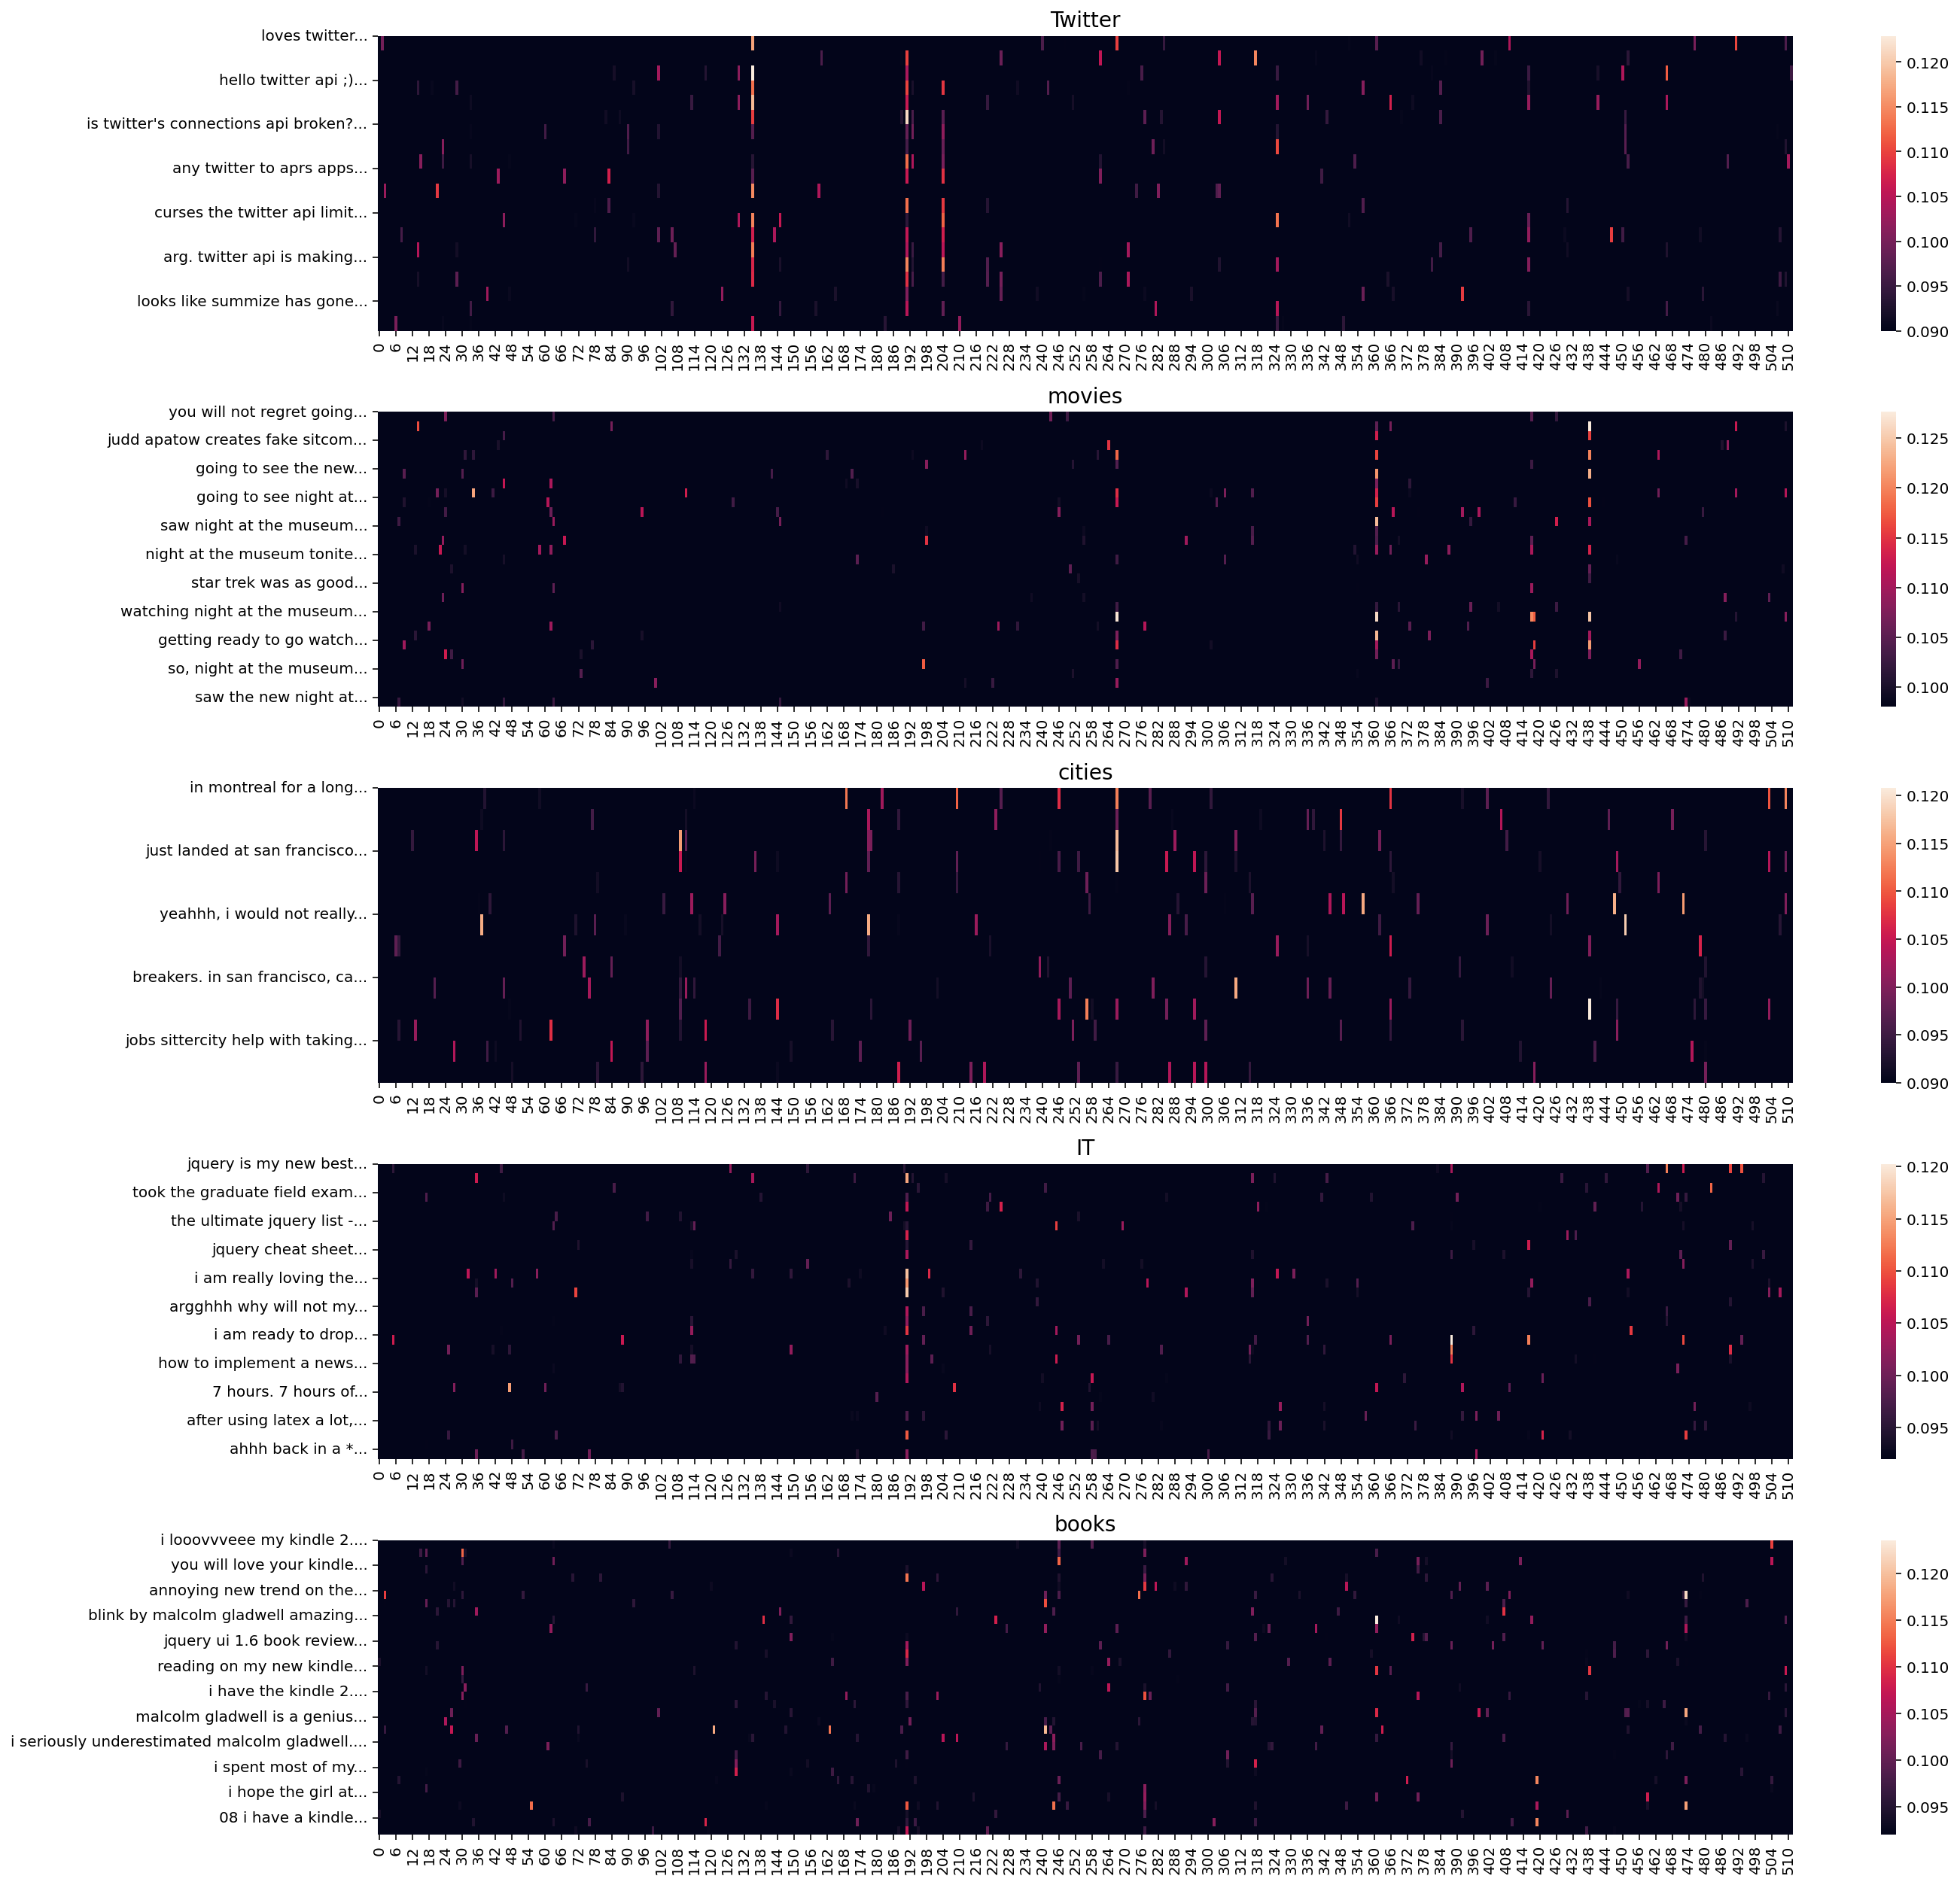

In [11]:
# Create list of selected topics
selected_topics = ['Twitter','movies','cities','IT','books']

# Plot embeddings by topic
fig,axes = plt.subplots(len(selected_topics),1,figsize=(20,3.5*len(selected_topics)))

for topic, ax in zip(selected_topics,axes.ravel()):
    
    # Get embeddings corresponding to a specific topic
    idx = df['topic'] == topic
    X_plot = X_embed[idx]
    
    # Ancor minimum value in colormap
    vmin   = tools.vmin_dict[topic]
    sns.heatmap(np.abs(X_plot),
                vmin=vmin,
                ax=ax)
    ax.set_title(topic,{'fontsize':14})
    ax.set_yticks(ticks = np.arange(0,len(X_plot),3))
    ax.set_yticklabels(labels=[tools.clean_tweet_plot(tweet) for tweet in df.loc[idx,'tweet']][0:len(X_plot):3],rotation=0)
    #ax.set_xticks([])
    
plt.tight_layout();

For each topic, what are the top 5 features that have the highest mean value?

In [12]:
for topic in selected_topics:
    
    print("Topic: " + topic)
    
    # Get embeddings corresponding to a specific topic
    idx = df['topic'] == topic
    X_topic = X_embed[idx]
    print("Largest mean feature" , X_topic.mean(axis=0).argmax())
    print("Largest 5 mean features:", np.argsort(-X_topic.mean(axis=0))[:5])
    print("\n")

Topic: Twitter
Largest mean feature 191
Largest 5 mean features: [191 204 261 113 284]


Topic: movies
Largest mean feature 361
Largest 5 mean features: [361 267 438 491  73]


Topic: cities
Largest mean feature 299
Largest 5 mean features: [299 267 111 480 448]


Topic: IT
Largest mean feature 191
Largest 5 mean features: [191 388  35 374 220]


Topic: books
Largest mean feature 473
Largest 5 mean features: [473 317 191  30 447]




### T-SNE biplots

Let's plot the various vector representations of text that we created previously. Then we can look for "patterns", such as clusters of documents. However, we can only plot data in 2 or 3 dimensions, not more. This means that we need to perform "dimensionality reduction", which consists of "compressing" the data into a few 2 (or 3) dimensions without losing too much information. 

Two popular "dimensionality reduction" techniques are:

- [Principal component analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [T-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline

decomp = make_pipeline(PCA(n_components=40), TSNE(n_components=2))

# BOW features
X_decomp_bow   = decomp.fit_transform(X_bow)
print('BOW features after PCA:\t\t',X_decomp_bow.shape)

# Embeddings
X_decomp_embed = decomp.fit_transform(X_embed)
print('Embeddings after PCA:\t\t',X_decomp_embed.shape)

BOW features after PCA:		 (498, 2)
Embeddings after PCA:		 (498, 2)


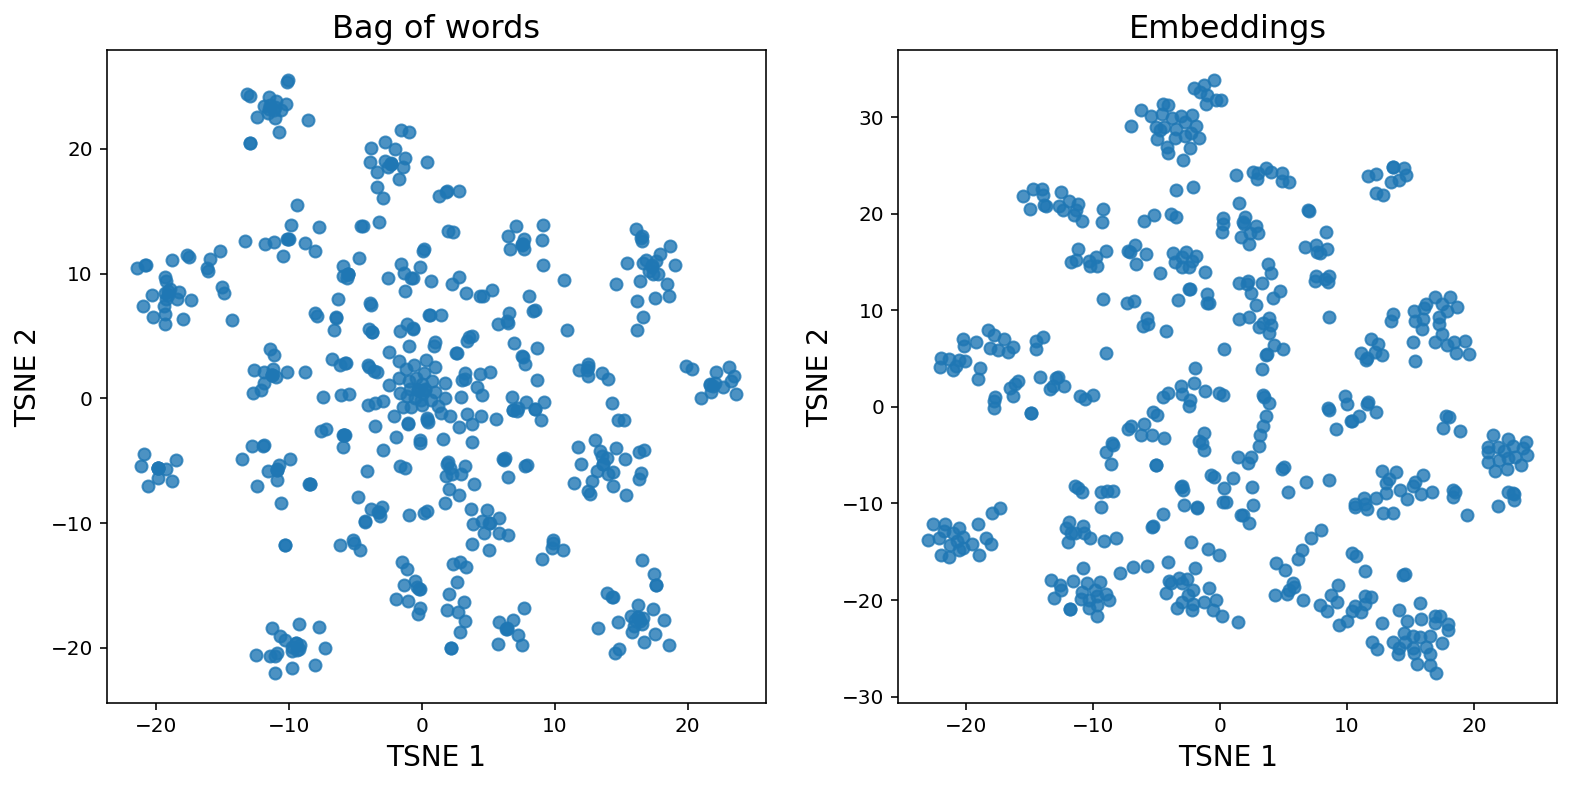

In [14]:
# Plot results

title_specs = {'fontsize':16}
label_specs = {'fontsize':14}
ticks_specs = {'fontsize':13}

fig,axes = plt.subplots(1,2,figsize=(13,6))

#Plot X_decomp_bow
axes[0].scatter(X_decomp_bow[:,0],X_decomp_bow[:,1],alpha=0.8)
axes[0].set_xlabel('TSNE 1',label_specs)
axes[0].set_ylabel('TSNE 2',label_specs);
axes[0].set_title('Bag of words',title_specs);

#Plot X_decomp_embed
axes[1].scatter(X_decomp_embed[:,0],X_decomp_embed[:,1],alpha=0.8)
axes[1].set_xlabel('TSNE 1',label_specs)
axes[1].set_ylabel('TSNE 2',label_specs);
axes[1].set_title('Embeddings',title_specs);

Each point in the plot represents a tweet. Let's see if we can find any patterns in these plots by color-coding data points according to the topic they belong to.

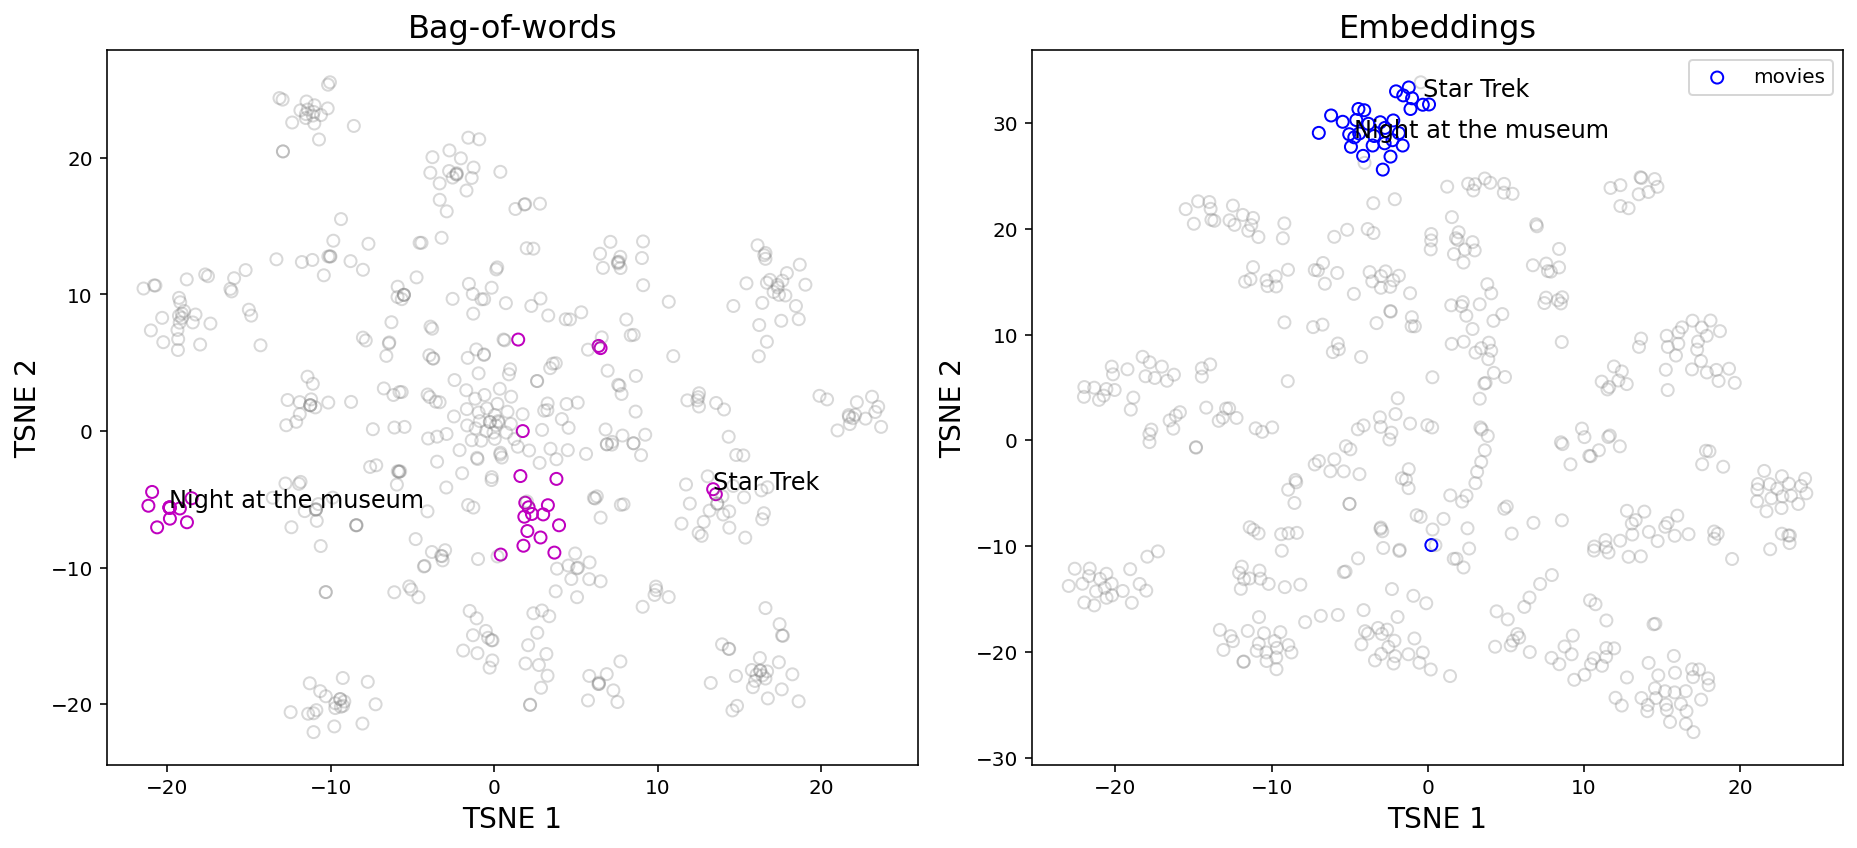

In [15]:
# Selected topics
selected_topics = ['movies', 'Twitter', 'politics', 'sports', 'IT']

tools.visualize_bow_embeddings(X_decomp_bow, X_decomp_embed, df, label='movies')

Each point in the plot represents a tweet. Using sentence embeddings here has allowed grouping tweets discussing the same topic, even if they don't always use the exact words or terms. For example, we can see that the sentence embeddings could detect similarities between, e.g. “Night at the museum” and “Star Trek” and then putting them close to each other in the plot.

On the other hand, Bag of words determines sentence similarity based on identical terms.

## Distance metrics for text similarity

If documents use the same words in the same proportions, then their document vectors will be closeby in the word space; they will be pointing in the same direction and having similar lengths.

We can compare vectors using: 
* the euclidean distance
* the cosine similarity

### Euclidean distance 

The euclidean distance is simply the length of the line connecting two points.

<img src="plots/eucl_dist.png" style="width:380px; height:270px;">

In [16]:
# Toy vectors

doc1 = np.array([1,3])
doc2 = np.array([16,2])
doc3 = np.array([18,5])

# Stack document vectors
docs = np.vstack([doc for doc in [doc1, doc2, doc3]])

# Print docs
docs

array([[ 1,  3],
       [16,  2],
       [18,  5]])

<img src="plots/doc_vectors.png" style="width:470px; height:330px;">

In [17]:
# Import euclidean_distances

from sklearn.metrics.pairwise import euclidean_distances

In [18]:
# Compute the euclidean distance between docs 1 - 3

index_labels = ['doc'+str(i+1) for i in range(0,3)]
column_labels = index_labels

pd.DataFrame(euclidean_distances(docs), index = index_labels, columns = ['doc'+str(i+1) for i in range(0,3)])

,doc1,doc2,doc3
doc1,0.000000,15.033296,17.117243
doc2,15.033296,0.000000,3.605551
doc3,17.117243,3.605551,0.000000


<img src="plots/doc_vectors.png" style="width:470px; height:330px;">

However, the euclidean distance can be misleading if used to compare vectors of different lengths. It's better to use the Euclidean distance with vectors of the same length. We will fist normalize the document vectors (ensuring they all have a length of 1) and will recompute the Euclidean distance. 

In [19]:
# Normalize toy vectors

tools.normalize_vector(docs)

array([[0.31622777, 0.9486833 ],
       [0.99227788, 0.12403473],
       [0.96351791, 0.26764386]])

In [20]:
# Compute euclidean distances using normalized toy vectors

pd.DataFrame(euclidean_distances(tools.normalize_vector(docs)), index = index_labels, columns = column_labels)

,doc1,doc2,doc3
doc1,0.000000,1.066344,0.939574
doc2,1.066344,0.000000,0.146461
doc3,0.939574,0.146461,0.000000


<img src="plots/doc_vectors_norm.png" style="width:470px; height:330px;">

### Cosine similarity

We saw that the Euclidean distance could be affected by the vectors' length. Another issue is that the euclidean distance is not a reasonable distance metric in high dimensions. (For more information, you can have a look at this [post](https://stats.stackexchange.com/questions/99171/why-is-euclidean-distance-not-a-good-metric-in-high-dimensions)).

The cosine similarity is commonly used to measure document similarity, as it isn't affected by the vectors' length or Euclidean distance’s problem with high dimensionality.

The cosine similarity is the cosine of the angle between two vectors. 

<img src="plots/cos_similarity.png" style="width:380px; height:270px;">

In [21]:
# Import cosine_similarity

from sklearn.metrics.pairwise import cosine_similarity

In [22]:
# Compute the cosine similarity

pd.DataFrame(cosine_similarity(docs), index = index_labels, columns = column_labels)

,doc1,doc2,doc3
doc1,1.000000,0.431455,0.558600
doc2,0.431455,1.000000,0.989275
doc3,0.558600,0.989275,1.000000


### Case study: The Twitter dataset

Now, I will look for similar tweets in the Twitter dataset, using the cosine similarity.

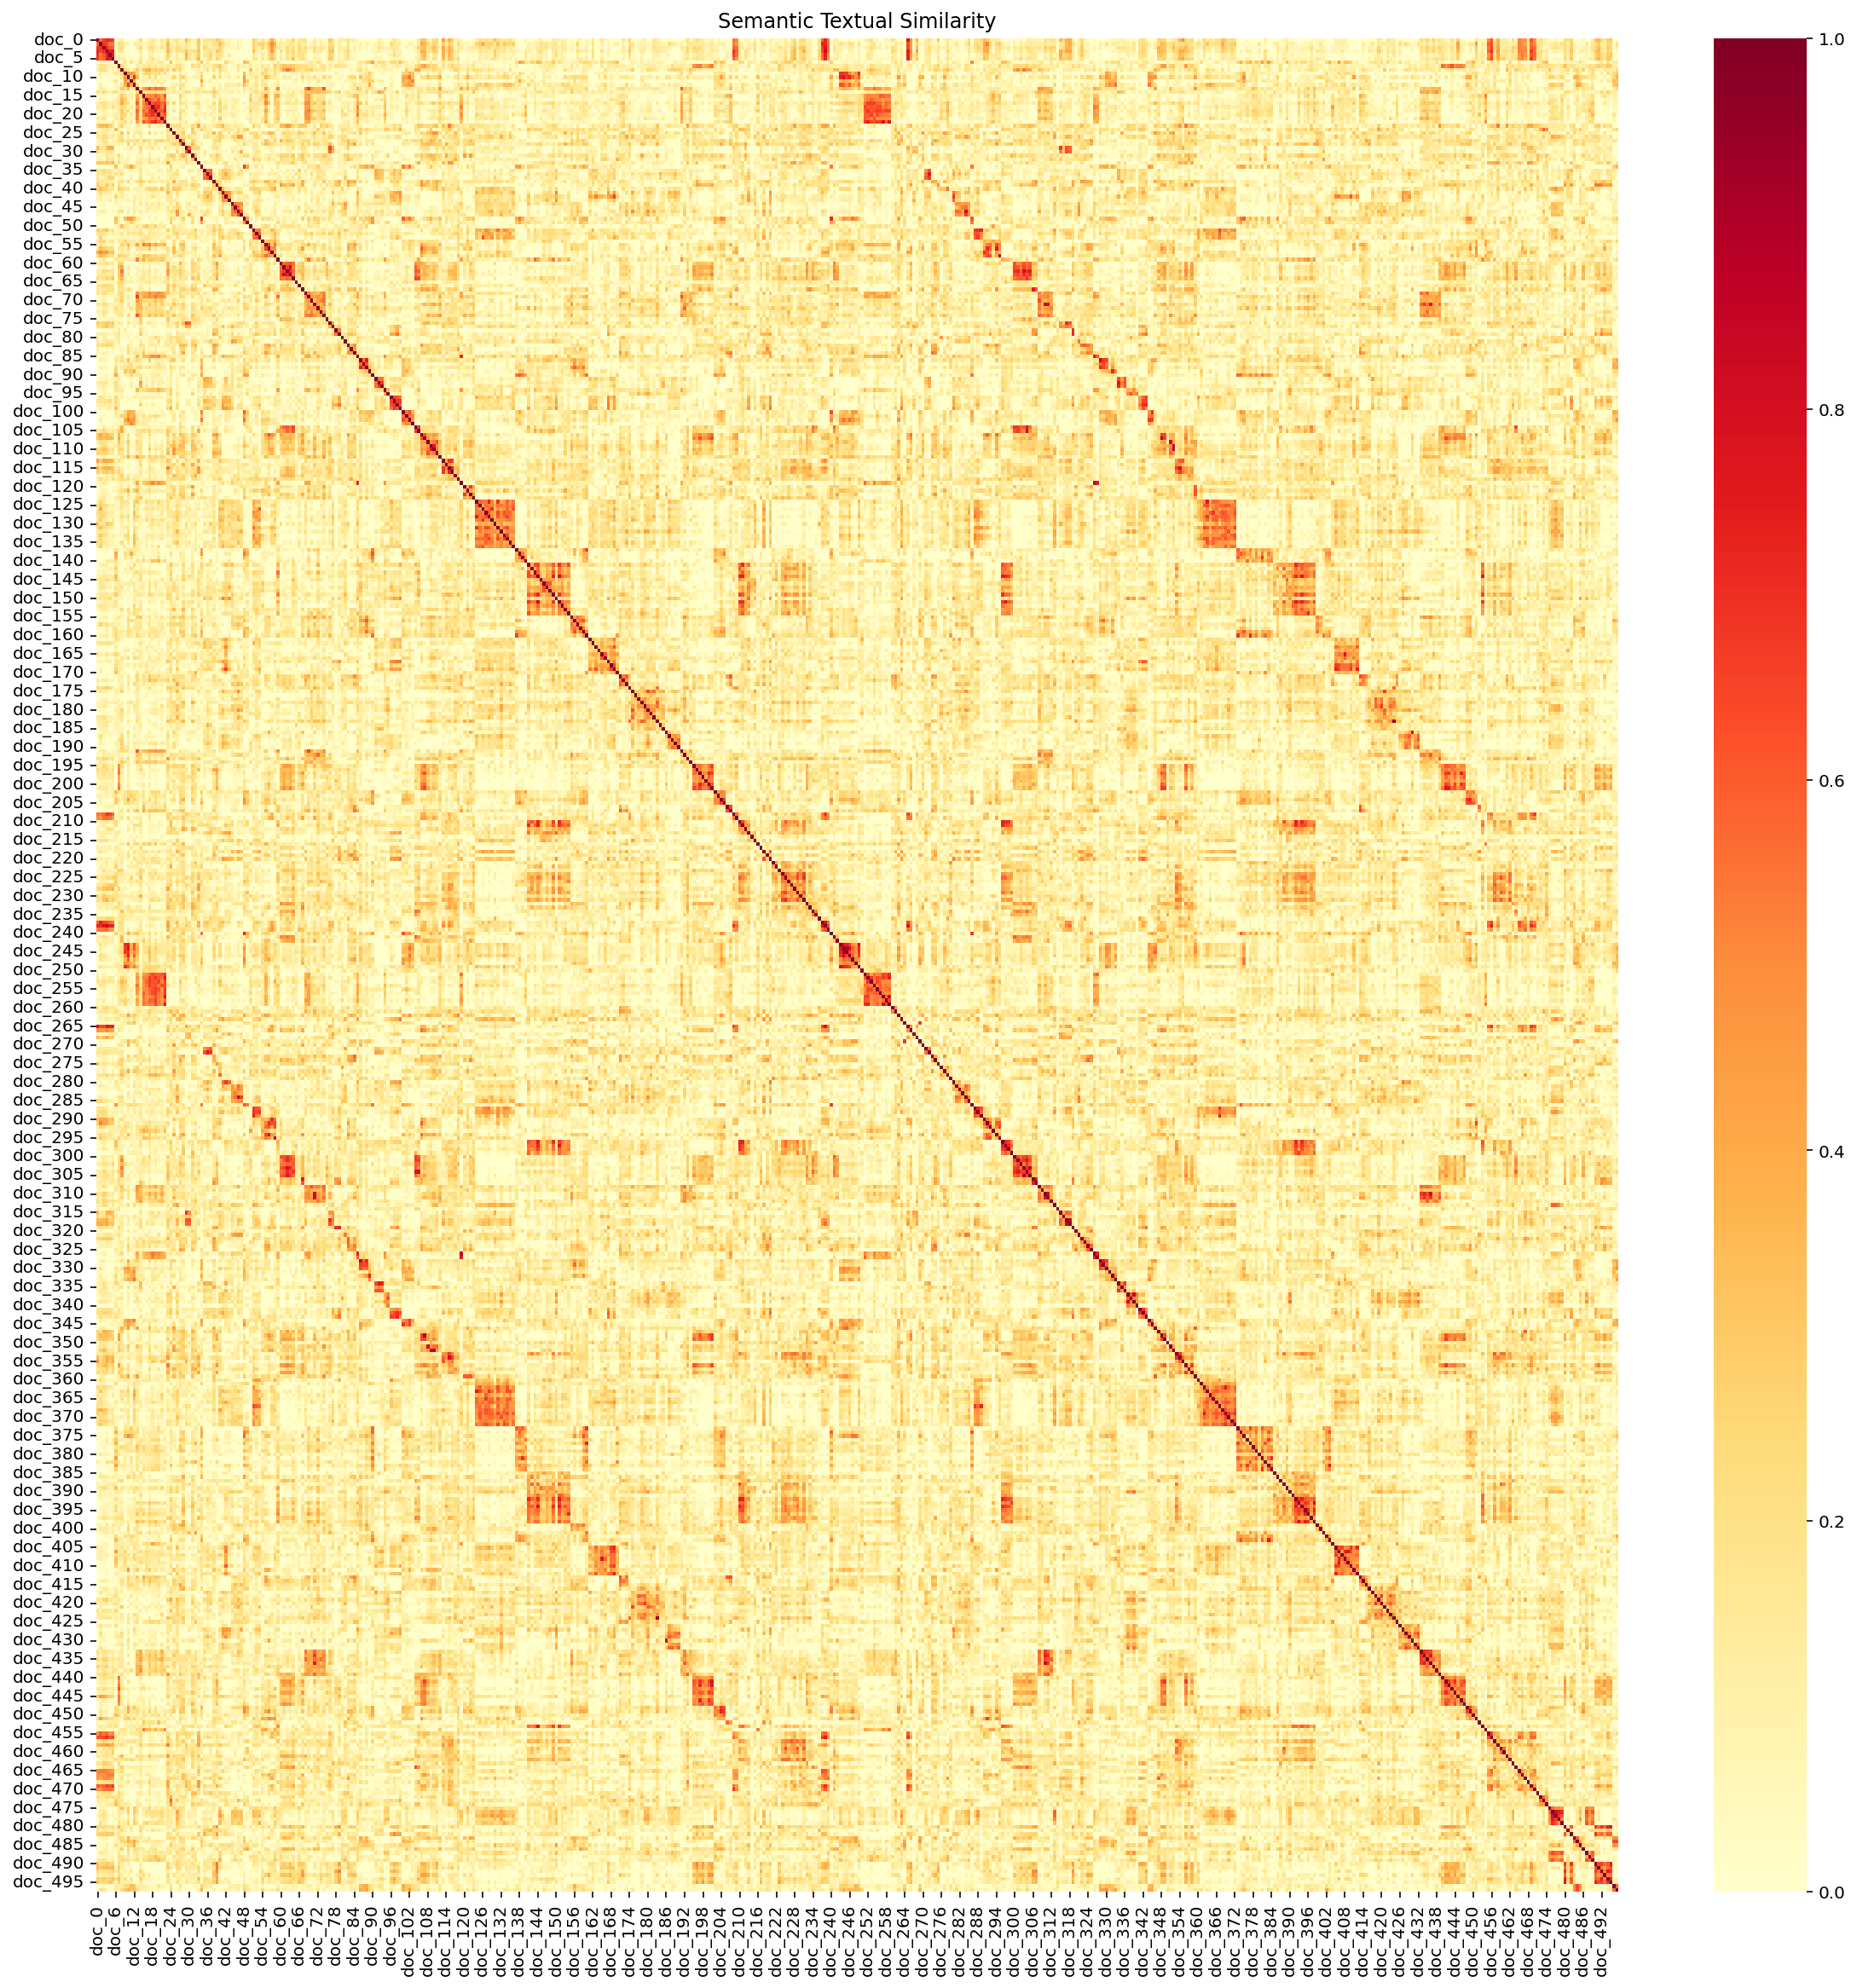

In [23]:
# Write your solution here

# Select features
X = X_embed

# Compute tweet similarity
similarity_df = pd.DataFrame(cosine_similarity(X))

similarity_df.index   = ['doc_'+str(i) for i in range(0,len(X))]
similarity_df.columns = ['doc_'+str(i) for i in range(0,len(X))]
similarity_df.head()

# Plot your results
tools.plot_similarity(similarity_df)

In [24]:
# Randomly sampled tweet

idx = random.randint(0,len(df)-1)
print('Doc idx: {}'.format(idx))

Doc idx: 28


In [25]:
# Show most similar tweets to it using cosine similarity.
pd.set_option('max_colwidth', None)
tools.find_neighbohrs(idx, X = X_embed, data = df)

,processed_tweet,cosine_similarity,euclidean_distance,label,topic
28,mluc custom innov award winner booz allen hamilton,1.000000,0.000000,pos,unlabeled
399,lawson head newedg hong kong busi china,0.435462,1.062580,neutral,politics
294,great articl malcolm_gladwel,0.431864,1.065961,pos,books
27,booz allen hamilton bad ass homegrown social collabor platform way cool ttiv,0.428066,1.069518,pos,unlabeled
84,new_blog post harvard versu stanford win,0.423677,1.073614,neutral,blogging
212,tri time_warner not nice record today :),0.412146,1.084301,neg,cable TV
386,time_warner ceo hint onlin fee magazin ap read mountain view unit state view,0.393843,1.101051,neutral,cable TV
262,share disruptionfr wilson slide talk googl hq,0.393390,1.101462,neutral,unlabeled
398,time_warner epic fail,0.392113,1.102621,neg,cable TV
204,warren_buffet economi,0.391733,1.102966,neutral,Warren Buffett


### Document clustering using K-Means

In [35]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pca = PCA()
X_embed_pca = pca.fit_transform(scaler.fit_transform(X_embed))

print(X_embed.shape)
print(X_embed_pca.shape)

(498, 512)
(498, 498)


In [36]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20, random_state=0).fit(X_embed_pca[:,:40])

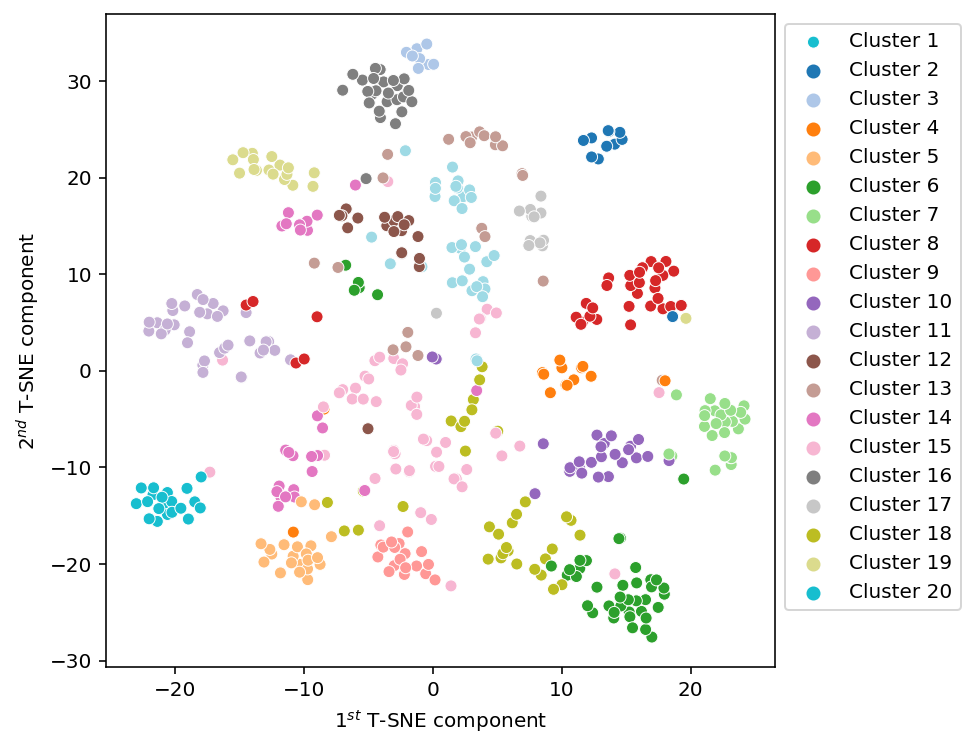

In [37]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=X_decomp_embed[:,0],y=X_decomp_embed[:,1], 
                hue = kmeans.labels_, 
                palette=sns.color_palette("tab20")[0:20],
                #alpha = 0.8
               )
plt.xlabel('$1^{st}$ T-SNE component')
plt.ylabel('$2^{nd}$ T-SNE component')
plt.legend(labels = ['Cluster {}'.format(i+1) for i in range(20)],bbox_to_anchor=(1,1))
plt.show();

In [39]:
for i in range(10):
    cluster_idx = kmeans.labels_ == i
    docs = df.loc[cluster_idx, 'processed_tweet']
    w = ' '.join([doc for doc in docs]).split()
    
    print('Cluster {}'.format('#'+str(i+1)))
    print('Common words: {}\n'.format(list(dict(Counter(w).most_common()).keys())[0:25]))

Cluster #1
Common words: ['love', 'canon', 'new', 'got', 'brand', 'eo', ':)', 'us', 'current', 'use', 'nikon', 'not', 'much', 'chose', 'video', 'featur', 'mistak', 'need', 'suggest', 'good', 'ir', 'filter', 'pl', 'dm', 'mp']

Cluster #2
Common words: ['star_trek', 'go_see', 'see_star', 'trek', 'not', 'night_museum', 'regret', 'awesom', 'way', 'esquir', 'soon', 'dad', 'went', 'movi', 'last_night', 'satisfi', 'wait', 'tonight', 'good', 'everyon', 'said', 'watch', 'programm', 'life', 'hitler']

Cluster #3
Common words: ['malcolm_gladwel', 'book', 'new', 'read', 'recommend', 'annoy', 'peopl', 'michael', 'want', 'highli', 'tip', 'point', 'great', 'realli', 'not', 'trend', 'internet', 'pick', 'apart', 'lewi', 'nobodi', 'bill', 'simmon', 'convers', 'blink']

Cluster #4
Common words: ['jqueri', 'book', 'javascript', 'use', 'css', 'learn', 'ui', 'review', 'ajax', 'safari', 'love', 'look', 'api', 'new', 'best', 'friend', 'bit', 'crazi', 'steep', 'curv', 'lyx', 'realli', 'good', 'long', 'doc']

C